In [3]:
# Cell 1: Setup and load processed data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# Load processed data
X = pd.read_csv(r"C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\features.csv")
y = pd.read_csv(r"C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\target.csv")

print("✓ Data loaded successfully!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())

✓ Data loaded successfully!
Features shape: (101766, 52)
Target shape: (101766, 1)

Class distribution:
early_readmit
0                90409
1                11357
Name: count, dtype: int64


In [4]:
# Cell 2: Train-Validation-Test Split
print("SPLITTING DATA")
print("="*70)

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

print(f"\nTrain class distribution:")
print(y_train.value_counts(normalize=True) * 100)

SPLITTING DATA
Training set: 71,236 samples
Validation set: 15,265 samples
Test set: 15,265 samples

Train class distribution:
early_readmit
0                88.839912
1                11.160088
Name: proportion, dtype: float64


In [5]:
# Cell 3: Baseline Model - Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*70)

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train baseline model with class weight to handle imbalance
baseline_model = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)

baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_val_scaled)
y_pred_proba_baseline = baseline_model.predict_proba(X_val_scaled)[:, 1]

# Evaluation
print("\n📊 VALIDATION SET PERFORMANCE:")
print(classification_report(y_val, y_pred_baseline, target_names=['Not Readmitted', 'Readmitted <30']))

auc_baseline = roc_auc_score(y_val, y_pred_proba_baseline)
print(f"\n🎯 AUC-ROC Score: {auc_baseline:.4f}")

BASELINE MODEL: LOGISTIC REGRESSION

📊 VALIDATION SET PERFORMANCE:
                precision    recall  f1-score   support

Not Readmitted       0.92      0.67      0.78     13561
Readmitted <30       0.17      0.55      0.26      1704

      accuracy                           0.66     15265
     macro avg       0.55      0.61      0.52     15265
  weighted avg       0.84      0.66      0.72     15265


🎯 AUC-ROC Score: 0.6522


BASELINE MODEL VISUALIZATIONS


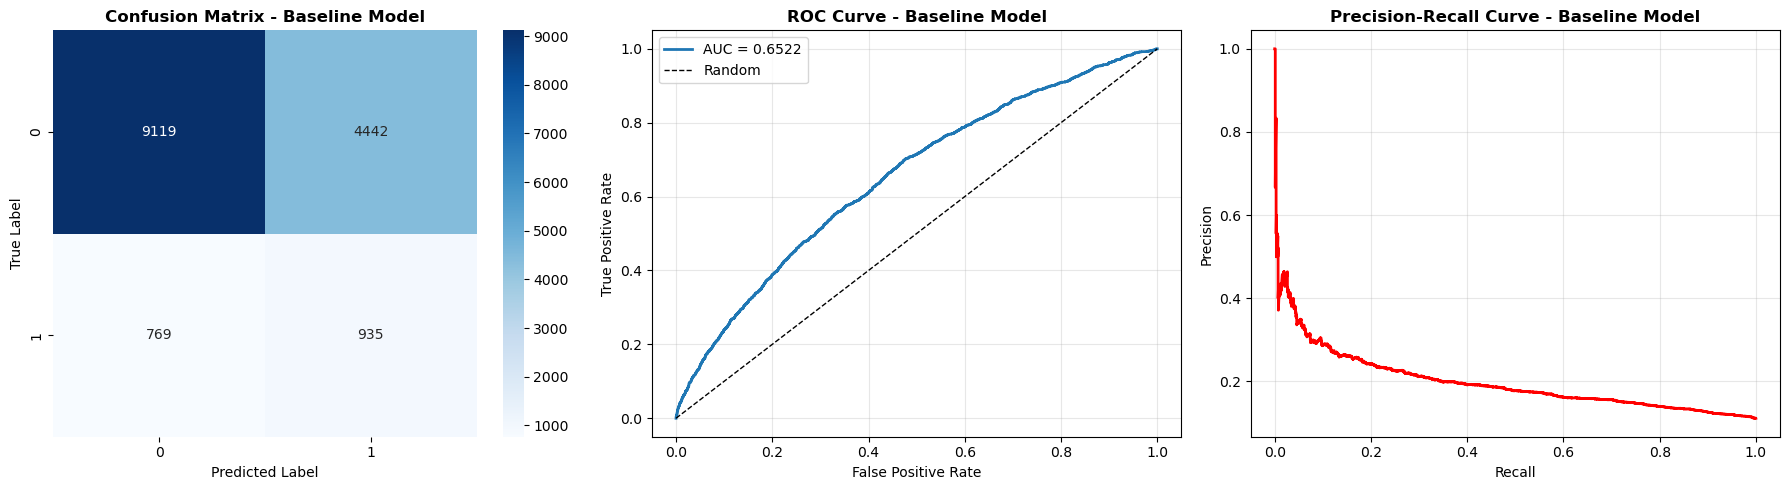

In [6]:
# Cell 4: Visualize baseline model performance
print("BASELINE MODEL VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Baseline Model', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_baseline)
axes[1].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc_baseline:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Baseline Model', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba_baseline)
axes[2].plot(recall, precision, linewidth=2, color='red')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - Baseline Model', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Cell 5: XGBoost Model (CORRECTED)
import xgboost as xgb

print("ADVANCED MODEL 1: XGBOOST")
print("="*70)

# Calculate scale_pos_weight for imbalance - convert to scalar
scale_pos_weight = float((y_train == 0).sum() / (y_train == 1).sum())
print(f"Scale pos weight (for class imbalance): {scale_pos_weight:.2f}")

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc'
)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              verbose=False)

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluation
print("\n📊 VALIDATION SET PERFORMANCE:")
print(classification_report(y_val, y_pred_xgb, target_names=['Not Readmitted', 'Readmitted <30']))

auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)
print(f"\n🎯 AUC-ROC Score: {auc_xgb:.4f}")

ADVANCED MODEL 1: XGBOOST
Scale pos weight (for class imbalance): 7.96

📊 VALIDATION SET PERFORMANCE:
                precision    recall  f1-score   support

Not Readmitted       0.93      0.69      0.79     13561
Readmitted <30       0.19      0.57      0.28      1704

      accuracy                           0.68     15265
     macro avg       0.56      0.63      0.54     15265
  weighted avg       0.84      0.68      0.74     15265


🎯 AUC-ROC Score: 0.6806


In [9]:
# Cell 6: LightGBM Model
import lightgbm as lgb

print("ADVANCED MODEL 2: LIGHTGBM")
print("="*70)

# Train LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    class_weight='balanced',  # Handles imbalance
    random_state=42,
    verbose=-1
)

lgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc')

# Predictions
y_pred_lgb = lgb_model.predict(X_val)
y_pred_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

# Evaluation
print("\n📊 VALIDATION SET PERFORMANCE:")
print(classification_report(y_val, y_pred_lgb, target_names=['Not Readmitted', 'Readmitted <30']))

auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
print(f"\n🎯 AUC-ROC Score: {auc_lgb:.4f}")

ADVANCED MODEL 2: LIGHTGBM

📊 VALIDATION SET PERFORMANCE:
                precision    recall  f1-score   support

Not Readmitted       0.93      0.68      0.78     13561
Readmitted <30       0.19      0.59      0.28      1704

      accuracy                           0.67     15265
     macro avg       0.56      0.63      0.53     15265
  weighted avg       0.85      0.67      0.73     15265


🎯 AUC-ROC Score: 0.6857


MODEL COMPARISON

📊 Model Performance Summary:
              Model  AUC-ROC  F1-Score
Logistic Regression 0.652155  0.264087
            XGBoost 0.680634  0.282380
           LightGBM 0.685684  0.281957

🏆 Best Model: LightGBM (AUC = 0.6857)


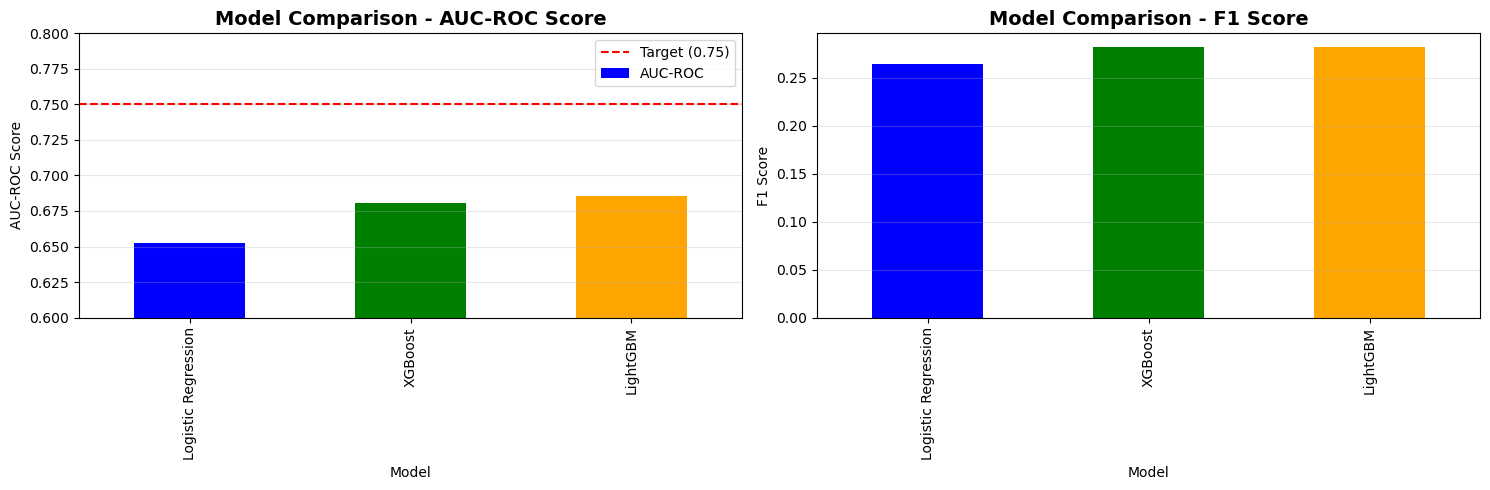

In [10]:
# Cell 7: Model Comparison
print("MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
models_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'LightGBM'],
    'AUC-ROC': [auc_baseline, auc_xgb, auc_lgb],
    'F1-Score': [
        f1_score(y_val, y_pred_baseline),
        f1_score(y_val, y_pred_xgb),
        f1_score(y_val, y_pred_lgb)
    ]
})

print("\n📊 Model Performance Summary:")
print(models_performance.to_string(index=False))

# Find best model
best_model_idx = models_performance['AUC-ROC'].idxmax()
best_model_name = models_performance.loc[best_model_idx, 'Model']
best_auc = models_performance.loc[best_model_idx, 'AUC-ROC']

print(f"\n🏆 Best Model: {best_model_name} (AUC = {best_auc:.4f})")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AUC comparison
models_performance.plot(x='Model', y='AUC-ROC', kind='bar', ax=axes[0], 
                        color=['blue', 'green', 'orange'], legend=False)
axes[0].set_title('Model Comparison - AUC-ROC Score', fontweight='bold', fontsize=14)
axes[0].set_ylabel('AUC-ROC Score')
axes[0].set_xlabel('Model')
axes[0].set_ylim([0.6, 0.8])
axes[0].axhline(y=0.75, color='red', linestyle='--', label='Target (0.75)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1-Score comparison
models_performance.plot(x='Model', y='F1-Score', kind='bar', ax=axes[1], 
                        color=['blue', 'green', 'orange'], legend=False)
axes[1].set_title('Model Comparison - F1 Score', fontweight='bold', fontsize=14)
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


ROC CURVE COMPARISON


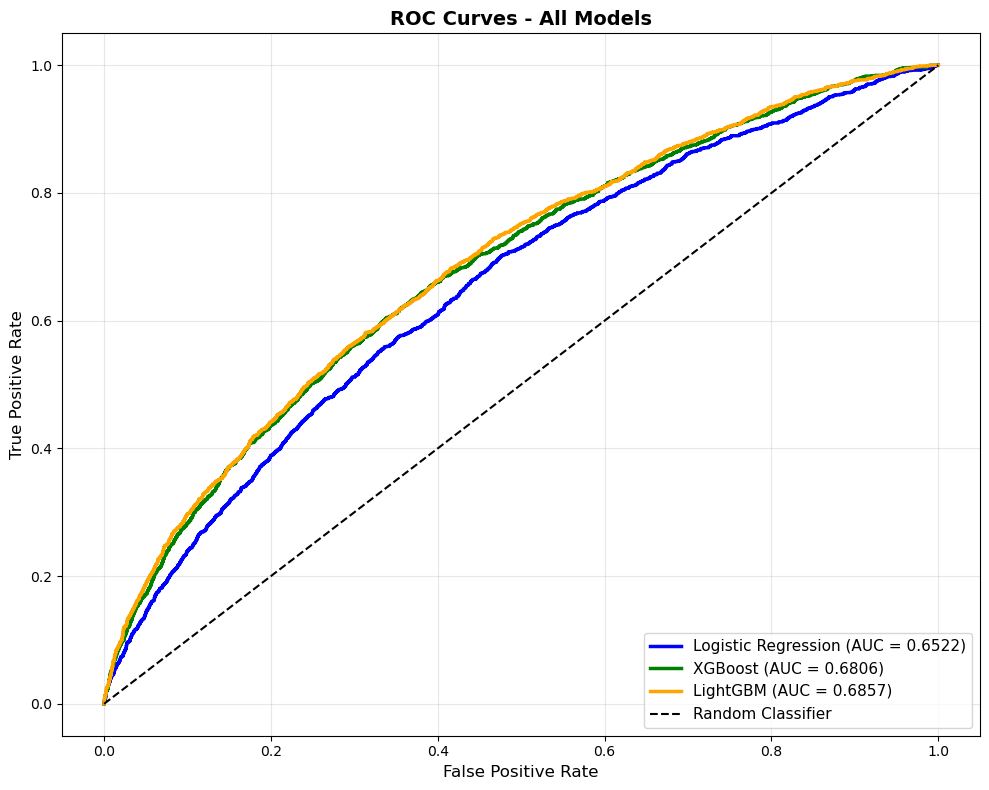

In [11]:
# Cell 8: ROC Curves - All Models
print("ROC CURVE COMPARISON")
print("="*70)

plt.figure(figsize=(10, 8))

# Plot all ROC curves
models_data = [
    ('Logistic Regression', y_pred_proba_baseline, 'blue'),
    ('XGBoost', y_pred_proba_xgb, 'green'),
    ('LightGBM', y_pred_proba_lgb, 'orange')
]

for name, y_proba, color in models_data:
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = roc_auc_score(y_val, y_proba)
    plt.plot(fpr, tpr, linewidth=2.5, label=f'{name} (AUC = {auc_score:.4f})', color=color)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                    Feature  Importance
           number_inpatient    0.219871
   discharge_disposition_id    0.078536
            on_diabetic_med    0.034804
           number_diagnoses    0.032729
             diag_1_encoded    0.029125
         payer_code_encoded    0.027547
          metformin_encoded    0.026797
        admission_source_id    0.026284
           number_emergency    0.026101
glyburide-metformin_encoded    0.025856
             diag_2_encoded    0.025023
          glipizide_encoded    0.024100
         total_interactions    0.023552
          number_outpatient    0.023310
           time_in_hospital    0.022768
             diag_3_encoded    0.022536
          admission_type_id    0.022426
               race_encoded    0.022234
                age_encoded    0.022233
            insulin_encoded    0.022178


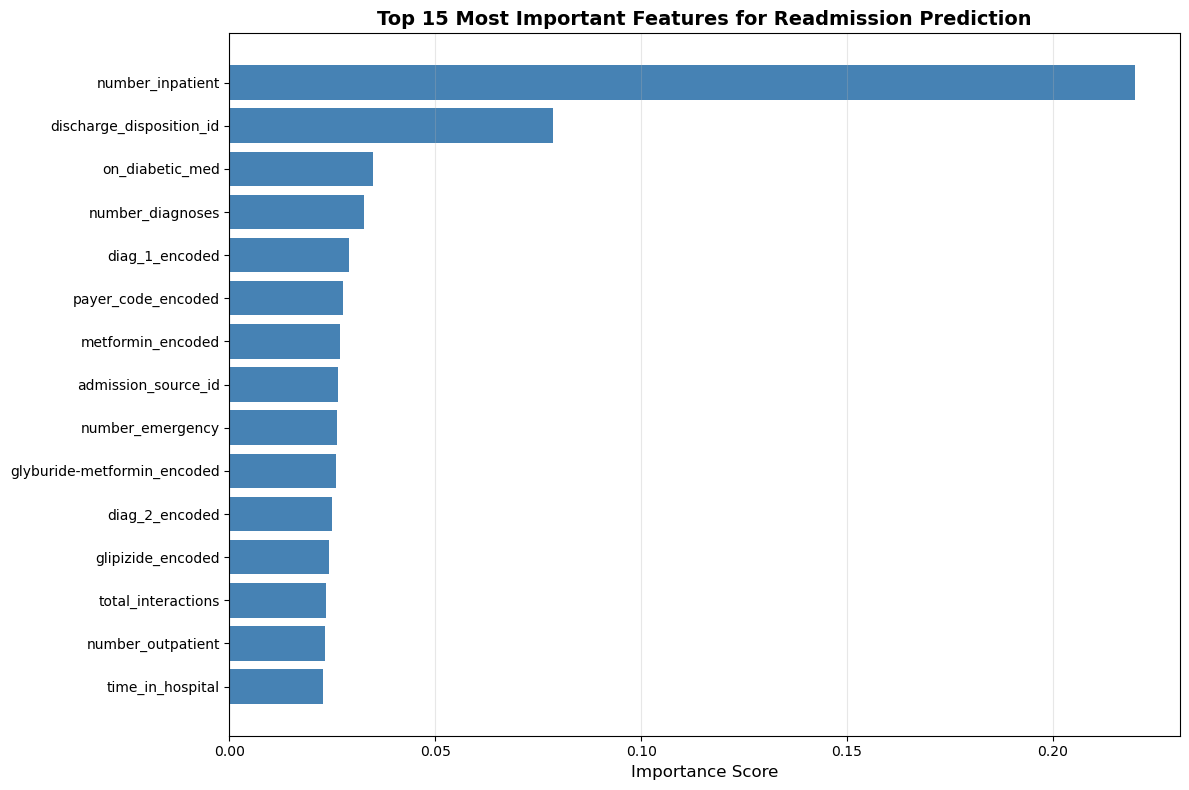

In [12]:
# Cell 9: Feature Importance (Best Model)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Use XGBoost for feature importance (typically performs well)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Most Important Features for Readmission Prediction', 
          fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Cell 11: Save the CORRECT best model (LightGBM)
print("SAVING CORRECT BEST MODEL")
print("="*70)

# Save LightGBM (the actual best performer)
lgb_filename = '../models/readmission_model_lgb.pkl'
joblib.dump(lgb_model, lgb_filename)

print(f"✓ LightGBM model saved to: {lgb_filename}")
print("\n📁 Current models:")
for file in os.listdir('../models'):
    print(f"  - {file}")

SAVING BEST MODEL
✓ Model saved to: ../models/readmission_model_xgb.pkl
✓ Scaler saved to: ../models/scaler.pkl

📁 Files in models directory:
  - readmission_model_xgb.pkl (0.37 MB)
  - scaler.pkl (0.00 MB)

MODEL DEVELOPMENT COMPLETE! 🎉

Best Model: LightGBM
Validation AUC: 0.6857
Target AUC: 0.75
Status: ⚠ Need improvement
